# Исследование надёжности заёмщиков

**Цель проекта:**

Определить критерии надёжности заёмщиков в зависимости от их статуса в разрезе критериев.

**Задачи проекта**:

Произвести анализ различных категорий клиентов, выявить в каждой категории наиболее и наименее платёжеспособных групп.

Импорт библиотек:

In [1]:
import pandas as pd
import seaborn

Выведем первые 20 строчек датафрейма `data` на экран:

In [3]:
data.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Выведем основную информацию о датафрейме:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Удаление пропусков

Выведем количество пропущенных значений для каждого столбца:

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения. Один из них — `days_employed`. Пропуски в этом столбце обработаем далее. Другой столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом:

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке. Таким артефактом будет отрицательное количество дней трудового стажа в столбце `days_employed`. Для реальных данных это нормально. Обработаем значения в этом столбце: заменим все отрицательные значения положительными:

In [7]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях:

In [8]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставьте их как есть. Тем более этот столбец не понадобится вам для исследования.

Выведем перечень уникальных значений столбца `children`:

In [9]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма `data`:

In [10]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

Ещё раз выведем перечень уникальных значений столбца `children`, чтобы убедиться, что артефакты удалены:

In [11]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Заполним пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type`:

In [12]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Убедимся, что все пропуски заполнены. Проверим себя и ещё раз выведем количество пропущенных значений для каждого столбца с помощью двух методов:

In [13]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный:

In [14]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Выведем на экран количество строк-дубликатов в данных. Если такие строки присутствуют, удалим их.

In [15]:
data.duplicated().sum()

54

In [16]:
data = data.drop_duplicates()

Обработаем неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру. Проверим остальные столбцы.

In [17]:
data['education'] = data['education'].str.lower()

### Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.


Например, кредитополучателю с доходом 25000 назначим категорию `'E'`, а клиенту, получающему 235000, — `'B'`. Используем собственную функцию с именем `categorize_income()`:

In [18]:
def categorize_income(income):
    if 0 <= income <= 30000:
        return 'E'
    elif 30001 <= income <= 50000:
        return 'D'
    elif 50001 <= income <= 200000:
        return 'C'
    elif 200001 <= income <= 1000000:
        return 'B'
    elif income >= 1000001:
        return 'A'

In [19]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведем на экран перечень уникальных целей взятия кредита из столбца `purpose`:

In [20]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

Например, если в столбце `purpose` находится подстрока `'на покупку автомобиля'`, то в столбце `purpose_category` должна появиться строка `'операции с автомобилем'`.

In [21]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [22]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследование данных

**Есть ли зависимость между количеством детей и возвратом кредита в срок?**

Подсчёт клиентов в разрезе различного количества детей 

In [23]:
debitors_by_children = data.groupby('children')['debt'].count()
debitors_by_children

children
0    14107
1     4809
2     2052
3      330
4       41
5        9
Name: debt, dtype: int64

Расчёт вероятности задолженности внутри групп

In [24]:
children_pivot = data.pivot_table(index = 'children', columns = 'debt', values = 'total_income', aggfunc = 'count')
children_pivot['rate'] = children_pivot[1] / debitors_by_children
children_pivot

debt,0,1,rate
children,,,
0,13044.0,1063.0,0.075353
1,4365.0,444.0,0.092327
2,1858.0,194.0,0.094542
3,303.0,27.0,0.081818
4,37.0,4.0,0.097561
5,9.0,NaN,NaN


Вывод столбчатой диаграммы для отображения результатов зависимости между количеством детей и возвратом кредита в срок

Text(0, 0.5, 'Количество клиентов с задолженностью')

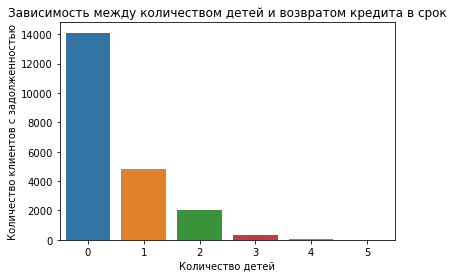

In [25]:
children_barplot = seaborn.barplot(x = [0, 1, 2, 3, 4, 5], y = data.groupby('children')['debt'].count())
children_barplot.axes.set_title('Зависимость между количеством детей и возвратом кредита в срок')
children_barplot.set_xlabel('Количество детей')
children_barplot.set_ylabel('Количество клиентов с задолженностью')

Вывод столбчатой диаграммы для отображения результатов вероятности задолженности среди групп

Text(0, 0.5, 'Доля клиентов с задолженностью')

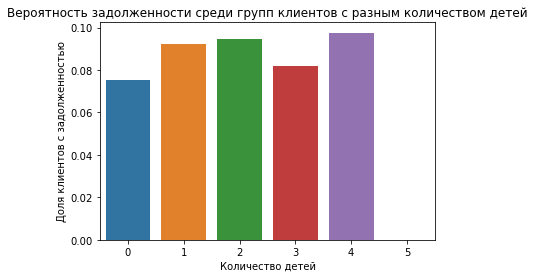

In [26]:
children_pivot_barplot = seaborn.barplot(x = [0, 1, 2, 3, 4, 5], y = children_pivot['rate'])
children_pivot_barplot.axes.set_title('Вероятность задолженности среди групп клиентов с разным количеством детей')
children_pivot_barplot.set_xlabel('Количество детей')
children_pivot_barplot.set_ylabel('Доля клиентов с задолженностью')


**Вывод:** Диаграмма наглядно отображает чёткую зависимость между количеством детей в семье клиента и возвратом кредита в срок - среди клиентов выборки наибольшее количество "должников" не имеют детей, а чем больше детей в семье - тем меньше вероятность возниновения задолженности по кредиту. 

Таким образом, чем больше детей в семье клиента, тем он более платёжеспособен.

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Подсчёт клиентов, имевших задолженность по выплате кредитов, в разрезе клиентов с разным семейным положением

In [27]:
debitors_by_family_status = data.groupby('family_status_id')['debt'].count()
debitors_by_family_status

family_status_id
0    12266
1     4146
2      951
3     1189
4     2796
Name: debt, dtype: int64

Расчёт вероятности задолженности внутри групп

In [28]:
family_status_pivot = data.pivot_table(index = 'family_status_id', columns = 'debt', values = 'total_income', aggfunc = 'count')
family_status_pivot['rate'] = family_status_pivot[1] / debitors_by_family_status
family_status_pivot

debt,0,1,rate
family_status_id,,,
0,11339,927,0.075575
1,3761,385,0.092861
2,888,63,0.066246
3,1105,84,0.070648
4,2523,273,0.097639


Вывод столбчатой диаграммы для отображения результатов зависимости между семейным положением и возвратом кредита в срок

Text(0, 0.5, 'Количество клиентов с задолженностью')

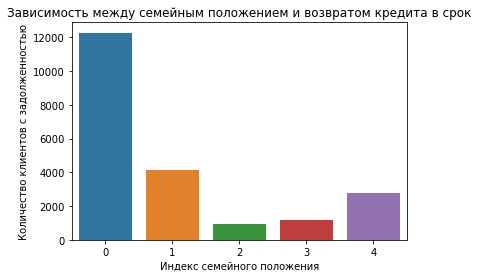

In [29]:
family_status_barplot = seaborn.barplot(x = [0, 1, 2, 3, 4], y = data.groupby('family_status_id')['debt'].count())
family_status_barplot.axes.set_title('Зависимость между семейным положением и возвратом кредита в срок')
family_status_barplot.set_xlabel('Индекс семейного положения')
family_status_barplot.set_ylabel('Количество клиентов с задолженностью')

Cоответствие семейного положения и индекса семейного положения

In [30]:
data[['family_status', 'family_status_id']].drop_duplicates()

,family_status,family_status_id
0,женат / замужем,0
4,гражданский брак,1
18,вдовец / вдова,2
19,в разводе,3
24,Не женат / не замужем,4


Вывод столбчатой диаграммы для отображения результатов вероятности задолженности среди групп

Text(0, 0.5, 'Доля клиентов с задолженностью')

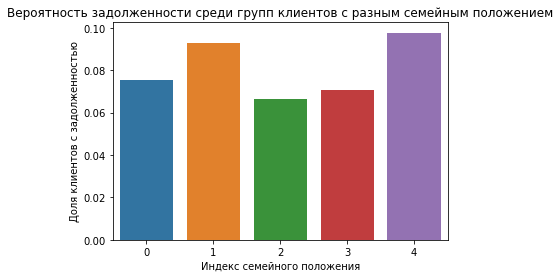

In [31]:
family_status_pivot_barplot = seaborn.barplot(x = [0, 1, 2, 3, 4], y = family_status_pivot['rate'])
family_status_pivot_barplot.axes.set_title('Вероятность задолженности среди групп клиентов с разным семейным положением')
family_status_pivot_barplot.set_xlabel('Индекс семейного положения')
family_status_pivot_barplot.set_ylabel('Доля клиентов с задолженностью')

**Вывод:** исходя из данной диаграммы можно с уверенностью сказать, что превалирующее количество клиентов, имеющих задолженность по выплате кредитов, являются семейными людьми (в статусе женат/замужем). Среди групп клиентов остальных статусов наименьшее количество "должников" являются вдовами/вдовцами или находятся в разводе. Среди неженатых/незамужних клиентов и клиентов, состоящих в гражданском браке, "должников" больше в 3 и 4 раза соответственно. 

Наименее платёжеспособными клиентами являются являются женатые клиенты, а наиболее - вдовы/вдовцы и находящиеся в разводе.

**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Подсчёт клиентов, имевших задолженность по выплате кредитов, в разрезе клиентов, имеющих разный уровень дохода

In [32]:
income_debitors = data.groupby('total_income_category')['debt'].count()
income_debitors

total_income_category
A       25
B     5014
C    15938
D      349
E       22
Name: debt, dtype: int64

Расчёт вероятности задолженности внутри групп

In [33]:
income_debitors_pivot = data.pivot_table(index = 'total_income_category', columns = 'debt', values = 'total_income', aggfunc = 'count')
income_debitors_pivot['rate'] = income_debitors_pivot[1] / income_debitors
income_debitors_pivot

debt,0,1,rate
total_income_category,,,
A,23,2,0.080000
B,4660,354,0.070602
C,14585,1353,0.084891
D,328,21,0.060172
E,20,2,0.090909


Вывод столбчатой диаграммы для отображения результатов зависимости между уровнем дохода и возвратом кредита в срок

Text(0, 0.5, 'Количество клиентов с задолженностью')

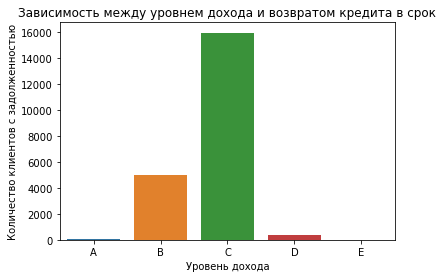

In [34]:
income_barplot = seaborn.barplot(x = ['A', 'B', 'C', 'D', 'E'], y = data.groupby('total_income_category')['debt'].count())
income_barplot.axes.set_title('Зависимость между уровнем дохода и возвратом кредита в срок')
income_barplot.set_xlabel('Уровень дохода')
income_barplot.set_ylabel('Количество клиентов с задолженностью')

Категории клиентов по уровню дохода:
- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

Вывод столбчатой диаграммы для отображения результатов вероятности задолженности среди групп

Text(0, 0.5, 'Доля клиентов с задолженностью')

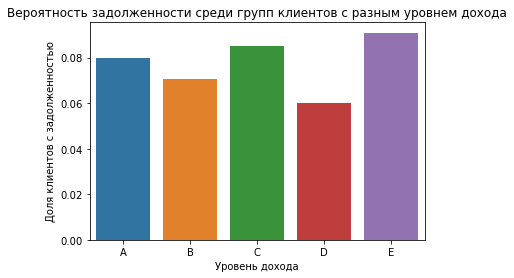

In [35]:
income_debitors_pivot_barplot = seaborn.barplot(x = ['A', 'B', 'C', 'D', 'E'], y = income_debitors_pivot['rate'])
income_debitors_pivot_barplot.axes.set_title('Вероятность задолженности среди групп клиентов с разным уровнем дохода')
income_debitors_pivot_barplot.set_xlabel('Уровень дохода')
income_debitors_pivot_barplot.set_ylabel('Доля клиентов с задолженностью')

**Вывод:** На основании данной диаграммы мы видим, что количество клиентов, имеющих задолженность по выплате кредита, является пиковой в категории дохода 'C' - это категория с доходом от 50 0001 до 200 000 руб. Клиенты с данным уровнем дохода являются наименее платёжеспособными.

В три раза меньше доля должников в категории 'B' - это категория с доходом от 200 001 до 1 000 000 руб.

При этом доля должников категорий 'A', 'D' и 'E' незначительна (категории с доходом до 50 000 руб. и свыше 1 000 000 руб.) - данные категории являются наиблее платёжеспособными.

**Как разные цели кредита влияют на его возврат в срок?**

Подсчёт клиентов, имевших задолженность по выплате кредитов, в разрезе клиентов, имеющих разные цели кредитования

In [36]:
purpose_debitors = data.groupby('purpose_category')['debt'].count()
purpose_debitors

purpose_category
операции с автомобилем       4281
операции с недвижимостью    10754
получение образования        3989
проведение свадьбы           2324
Name: debt, dtype: int64

Расчёт вероятности задолженности внутри групп

In [37]:
purpose_debitors_pivot = data.pivot_table(index = 'purpose_category', columns = 'debt', values = 'total_income', aggfunc = 'count')
purpose_debitors_pivot['rate'] = purpose_debitors_pivot[1] / purpose_debitors
purpose_debitors_pivot

debt,0,1,rate
purpose_category,,,
операции с автомобилем,3881,400,0.093436
операции с недвижимостью,9974,780,0.072531
получение образования,3620,369,0.092504
проведение свадьбы,2141,183,0.078744


Вывод столбчатой диаграммы для наглядного отображения результатов

Text(0.5, 0, 'Количество клиентов с задолженностью')

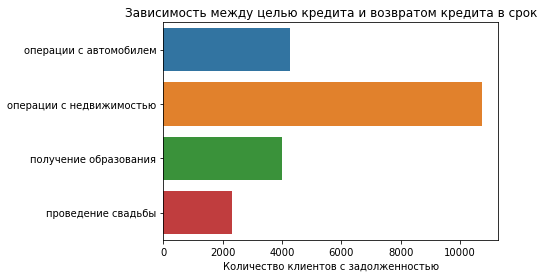

In [38]:
purpose_barplot = seaborn.barplot(x = data.groupby('purpose_category')['debt'].count(), y = ['операции с автомобилем', 'операции с недвижимостью', 'получение образования', 'проведение свадьбы'])
purpose_barplot.axes.set_title('Зависимость между целью кредита и возвратом кредита в срок')
purpose_barplot.set_xlabel('Количество клиентов с задолженностью')

Вывод столбчатой диаграммы для отображения результатов вероятности задолженности среди групп

Text(0.5, 0, 'Доля клиентов с задолженностью')

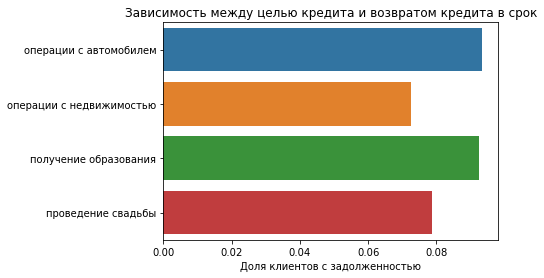

In [39]:
purpose_debitors_pivot_barplot = seaborn.barplot(x = purpose_debitors_pivot['rate'], y = ['операции с автомобилем', 'операции с недвижимостью', 'получение образования', 'проведение свадьбы'])
purpose_debitors_pivot_barplot.axes.set_title('Зависимость между целью кредита и возвратом кредита в срок')
purpose_debitors_pivot_barplot.set_xlabel('Доля клиентов с задолженностью')

**Вывод:** Из диаграммы выше следует, что кредиты, взятые на цели операций с недвижимостью, клиенты чаще не возвращают в срок, чем кредиты, взятые на другие цели - здесь количество клиентов, имеющих задолженность, значительно больше.

По кредитам, взятым для проведения свадьбы, количество должников наименьшее.

В два раза больше задолженностей по кредитам, взятым для целей проведения операций с автомобилями и получения образования.

**Возможные причины появления пропусков в исходных данных.**

Причины могут быть следующими:
1. Ошибки при выгрузке данных;
2. Ошибки при преобразовании данных из одного типа в другой;
3. Ошибки при внесении данных в базы сотрудниками банка (невнесение данных);
4. Непредоставление данных клиентами;
5. Отсутствие данных как таковых.

Однако, учитывая, что пропуски данных относятся к трудовому стажу и ежемесячному доходу, вероятность причин №№ 4 и 5 крайне низка, т.к. без этих данных банк вряд ли выдаст кредит клиенту.

**Почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.**

При заполнении пропусков средним значением можно сильно исказить результаты исследования, т.к. в данных могут встречаться аномальные значения, значительным образом влияющие непосредственно на средние значения даже при небольшом их количестве. Медианное значение отражает более объективную информацию, поскольку ровно по половине значений будет меньше и больше медианы.

## Общий вывод.

Результаты проведённого исследования показывают, что платёжеспособность клиентов банка на основании предоставленных данных зависит от нескольких факторов - семейного положения, количества детей, уровня дохода, цели кредита. 

Для каждого из факторов существуют явно выделющиеся категории клиентов как с наиболее низкой платёжеспособностью, а именно:
1. Клиенты, не имеющие детей;
2. Клиенты, состоящие в браке;
3. Клиенты, имеющие средний уровень дохода (от 50 001 руб. до 200 000 руб.);
4. Клиенты, берущие кредиты для осуществления операций с недвижимостью;

Так и категории наиболее платёжеспособных клиентов:
1. Семьи с большим количеством детей (от 3-х и более);
2. Клиенты, находящиеся в разводе и вдовы/вдовцы;
3. Клиенты, имеющие уровень дохода до 50 000 руб. и свыше 1 000 000 руб.;
4. Клиенты, берущие кредиты для проведения свадеб.

Таким образом, рассматривая совокупность данных о потенциальном клиенте в разрезе результатов проведённого анализа можно довольно точно оценить уровень его платёжеспособности.